# CROMD – Formulacao Cut-Set com Branch-and-Cut (CPLEX)

Este notebook implementa o modelo base (sem conectividade explicita) e adiciona conectividade via callbacks:
- User cuts para solucoes fracionarias (min-cut/cut-set)
- Lazy constraints para solucoes inteiras (obrigatorio)

Nota: user cuts nao substituem lazy constraints; sem lazy o modelo e invalido.

Selecao do separador:
- `SEPARATOR = "networkx"`: Gomory-Hu via NetworkX no grafo auxiliar
- `SEPARATOR = "custom_gomory_hu"`: implementacao propria (Dinic + Gomory-Hu)


In [1]:
import time
from typing import Dict, Any, Iterable, List, Set, Tuple

import cplex
from cplex import SparsePair
import networkx as nx


In [2]:
def _compute_coverers(N_list, Viz):
    n_set = set(N_list)
    coverers = {i: set() for i in N_list}
    for j in N_list:
        cov_plus = set(Viz[j]) if j < len(Viz) else set()
        cov_plus.add(j)
        if 0 in cov_plus:
            cov_plus.discard(0)
        for i in cov_plus:
            if i in n_set:
                coverers[i].add(j)
    return {i: sorted(coverers[i]) for i in N_list}

def build_cromd_cut_set_model(V, N, A, d, C, K, Viz):
    V_list = list(V)
    N_list = list(N)
    A_list = list(A)
    drone_ids = list(range(K))

    assert 0 in V_list, "Base 0 must be in V"
    assert 0 not in N_list, "Base 0 must not be in N"

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    var_index: Dict[str, Any] = {}

    coverers = _compute_coverers(N_list, Viz)
    var_index["coverers"] = coverers

    def add_block(names, types, lb=None, ub=None, obj=None):
        if lb is None:
            lb = [0.0] * len(names)
        if ub is None:
            ub = [cplex.infinity] * len(names)
        if obj is None:
            obj = [0.0] * len(names)
        start = cpx.variables.get_num()
        cpx.variables.add(names=names, types=types, lb=lb, ub=ub, obj=obj)
        return list(range(start, start + len(names)))

    # T
    t_indices = add_block(["T"], ["C"], lb=[0.0], ub=[cplex.infinity], obj=[1.0])
    var_index["T"] = t_indices[0]

    # u
    u_names = [f"u_{k}" for k in drone_ids]
    u_indices = add_block(u_names, ["B"] * len(u_names), lb=[0.0] * len(u_names), ub=[1.0] * len(u_names))
    u_index = {k: idx for k, idx in zip(drone_ids, u_indices)}
    var_index["u"] = u_index
    var_index["u_indices"] = u_indices

    # y
    y_names = [f"y_{k}_{i}" for k in drone_ids for i in N_list]
    y_indices = add_block(y_names, ["B"] * len(y_names), lb=[0.0] * len(y_names), ub=[1.0] * len(y_names))
    y_index = {}
    y_idx_by_k = {}
    y_pos_by_i = {i: [] for i in N_list}
    pos = 0
    for k in drone_ids:
        y_idx_by_k[k] = y_indices[pos:pos + len(N_list)]
        for i, idx in zip(N_list, y_idx_by_k[k]):
            y_index[(k, i)] = idx
            y_pos_by_i[i].append(pos)
            pos += 1
    var_index["y"] = y_index
    var_index["y_indices"] = y_indices
    var_index["y_keys"] = [(k, i) for k in drone_ids for i in N_list]
    var_index["y_pos_by_i"] = y_pos_by_i

    # x
    x_names = [f"x_{k}_{i}_{j}" for k in drone_ids for (i, j) in A_list]
    x_indices = add_block(x_names, ["B"] * len(x_names), lb=[0.0] * len(x_names), ub=[1.0] * len(x_names))
    x_index = {}
    x_idx_by_k = {}
    x_keys = [(k, i, j) for k in drone_ids for (i, j) in A_list]
    pos = 0
    for k in drone_ids:
        x_idx_by_k[k] = x_indices[pos:pos + len(A_list)]
        for (i, j), idx in zip(A_list, x_idx_by_k[k]):
            x_index[(k, i, j)] = idx
        pos += len(A_list)
    var_index["x"] = x_index
    var_index["x_indices"] = x_indices
    var_index["x_keys"] = x_keys
    var_index["x_idx_by_k"] = x_idx_by_k

    d_vals = [d[(i, j)] for (i, j) in A_list]

    # 1) Makespan
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        indices = x_idx_by_k[k] + [var_index["T"]]
        values = d_vals + [-1.0]
        lin_expr.append(SparsePair(ind=indices, val=values))
        senses.append("L")
        rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 2) Autonomia
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        lin_expr.append(SparsePair(ind=x_idx_by_k[k], val=d_vals))
        senses.append("L")
        rhs.append(C)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 3) Saida e retorno a base
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        out_indices = [x_index[(k, 0, j)] for j in N_list]
        in_indices = [x_index[(k, j, 0)] for j in N_list]
        lin_expr.append(SparsePair(ind=out_indices + [u_index[k]], val=[1.0] * len(out_indices) + [-1.0]))
        senses.append("E")
        rhs.append(0.0)
        lin_expr.append(SparsePair(ind=in_indices + [u_index[k]], val=[1.0] * len(in_indices) + [-1.0]))
        senses.append("E")
        rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 4) Grau nos sensores visitados
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        for i in N_list:
            out_indices = [x_index[(k, i, j)] for j in V_list if j != i]
            in_indices = [x_index[(k, j, i)] for j in V_list if j != i]
            lin_expr.append(SparsePair(ind=out_indices + [y_index[(k, i)]], val=[1.0] * len(out_indices) + [-1.0]))
            senses.append("E")
            rhs.append(0.0)
            lin_expr.append(SparsePair(ind=in_indices + [y_index[(k, i)]], val=[1.0] * len(in_indices) + [-1.0]))
            senses.append("E")
            rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 5) Ativacao
    lin_expr = []
    senses = []
    rhs = []
    for k in drone_ids:
        for i in N_list:
            lin_expr.append(SparsePair(ind=[y_index[(k, i)], u_index[k]], val=[1.0, -1.0]))
            senses.append("L")
            rhs.append(0.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 6) Simetria
    lin_expr = []
    senses = []
    rhs = []
    for k in range(K - 1):
        lin_expr.append(SparsePair(ind=[u_index[k + 1], u_index[k]], val=[1.0, -1.0]))
        senses.append("L")
        rhs.append(0.0)
        indices = x_idx_by_k[k] + x_idx_by_k[k + 1]
        values = d_vals + [-v for v in d_vals]
        lin_expr.append(SparsePair(ind=indices, val=values))
        senses.append("G")
        rhs.append(0.0)
    if lin_expr:
        cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 7) Cobertura
    lin_expr = []
    senses = []
    rhs = []
    for i in N_list:
        cover_nodes = list(coverers[i])
        if i not in cover_nodes:
            cover_nodes.append(i)
        indices = [y_index[(k, j)] for k in drone_ids for j in cover_nodes]
        lin_expr.append(SparsePair(ind=indices, val=[1.0] * len(indices)))
        senses.append("G")
        rhs.append(1.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    # 8) Visita unica
    lin_expr = []
    senses = []
    rhs = []
    for i in N_list:
        indices = [y_index[(k, i)] for k in drone_ids]
        lin_expr.append(SparsePair(ind=indices, val=[1.0] * len(indices)))
        senses.append("L")
        rhs.append(1.0)
    cpx.linear_constraints.add(lin_expr=lin_expr, senses=senses, rhs=rhs)

    var_index["V_list"] = V_list
    var_index["N_list"] = N_list
    var_index["A_list"] = A_list
    var_index["drone_ids"] = drone_ids

    return cpx, var_index


In [3]:
class Dinic:
    def __init__(self, n):
        self.n = n
        self.graph: List[List[Dict[str, Any]]] = [[] for _ in range(n)]

    def add_edge(self, fr, to, cap):
        fwd = {"to": to, "cap": cap, "rev": None}
        rev = {"to": fr, "cap": 0.0, "rev": fwd}
        fwd["rev"] = rev
        self.graph[fr].append(fwd)
        self.graph[to].append(rev)

    def add_undirected(self, u, v, cap):
        self.add_edge(u, v, cap)
        self.add_edge(v, u, cap)

    def max_flow(self, s, t):
        flow = 0.0
        eps = 1e-9
        while True:
            level = [-1] * self.n
            queue = [s]
            level[s] = 0
            for v in queue:
                for edge in self.graph[v]:
                    if edge["cap"] > eps and level[edge["to"]] < 0:
                        level[edge["to"]] = level[v] + 1
                        queue.append(edge["to"])
            if level[t] < 0:
                break
            it = [0] * self.n

            def dfs(v, f):
                if v == t:
                    return f
                for i in range(it[v], len(self.graph[v])):
                    it[v] = i
                    edge = self.graph[v][i]
                    if edge["cap"] <= eps or level[v] >= level[edge["to"]]:
                        continue
                    d = dfs(edge["to"], min(f, edge["cap"]))
                    if d > eps:
                        edge["cap"] -= d
                        edge["rev"]["cap"] += d
                        return d
                return 0.0

            while True:
                pushed = dfs(s, float("inf"))
                if pushed <= eps:
                    break
                flow += pushed
        return flow

    def min_cut_side(self, s):
        eps = 1e-9
        seen = [False] * self.n
        stack = [s]
        seen[s] = True
        while stack:
            v = stack.pop()
            for edge in self.graph[v]:
                if edge["cap"] > eps and not seen[edge["to"]]:
                    seen[edge["to"]] = True
                    stack.append(edge["to"])
        return {i for i, flag in enumerate(seen) if flag}


def max_flow_min_cut(n, edges, s, t):
    dinic = Dinic(n)
    for u, v, cap in edges:
        if cap > 0.0:
            dinic.add_undirected(u, v, cap)
    flow = dinic.max_flow(s, t)
    side = dinic.min_cut_side(s)
    return flow, side


def gomory_hu_custom(n, edges):
    parent = [0] * n
    value = [0.0] * n
    cut_sets: List[Set[int]] = [set() for _ in range(n)]

    for s in range(1, n):
        t = parent[s]
        flow, side = max_flow_min_cut(n, edges, s, t)
        value[s] = flow
        cut_sets[s] = side
        for i in range(s + 1, n):
            if parent[i] == t and i in side:
                parent[i] = s
        if t in side:
            prev_parent_t = parent[t]
            prev_value_t = value[t]
            prev_cut_t = cut_sets[t]
            parent[s] = prev_parent_t
            value[s] = prev_value_t
            cut_sets[s] = prev_cut_t
            parent[t] = s
            value[t] = flow
            cut_sets[t] = side

    return parent, value, cut_sets


def min_edge_to_root(node, parent, value):
    min_val = float("inf")
    min_node = None
    v = node
    while v != 0:
        if value[v] < min_val:
            min_val = value[v]
            min_node = v
        v = parent[v]
    return min_node, min_val


def y_sum(i, y_vals, y_pos_by_i):
    total = 0.0
    for pos in y_pos_by_i[i]:
        total += y_vals[pos]
    return total


def choose_anchor(S, y_vals, y_pos_by_i):
    best = None
    best_val = -1.0
    for i in S:
        val = y_sum(i, y_vals, y_pos_by_i)
        if val > best_val + 1e-12 or (abs(val - best_val) <= 1e-12 and (best is None or i < best)):
            best = i
            best_val = val
    return best, best_val


def build_active_set(y_vals, y_pos_by_i, N_list, eps):
    W = []
    for i in N_list:
        total = y_sum(i, y_vals, y_pos_by_i)
        if total > eps:
            W.append(i)
    return W


def build_capacities(x_vals, x_keys, node_set, eps):
    cap = {}
    for (k, i, j), val in zip(x_keys, x_vals):
        if val <= eps:
            continue
        if i not in node_set or j not in node_set:
            continue
        a, b = (i, j) if i < j else (j, i)
        cap[(a, b)] = cap.get((a, b), 0.0) + val
    return cap


def components_from_cap(nodes, cap, threshold):
    adj = {n: set() for n in nodes}
    for (i, j), val in cap.items():
        if val >= threshold:
            adj[i].add(j)
            adj[j].add(i)
    components = []
    visited = set()
    for node in nodes:
        if node in visited:
            continue
        stack = [node]
        visited.add(node)
        comp = {node}
        while stack:
            v = stack.pop()
            for nbr in adj[v]:
                if nbr not in visited:
                    visited.add(nbr)
                    comp.add(nbr)
                    stack.append(nbr)
        components.append(comp)
    return components


def separate_cuts_networkx(nodes, cap):
    nodes = list(nodes)
    if len(nodes) <= 1:
        return []

    if not hasattr(nx, "gomory_hu_tree"):
        raise RuntimeError("networkx.gomory_hu_tree is not available in this environment")

    G = nx.Graph()
    G.add_nodes_from(nodes)
    for (i, j), val in cap.items():
        if val > EPS_ACT:
            G.add_edge(i, j, cap=val)

    cuts: List[Tuple[frozenset, float]] = []
    if not nx.is_connected(G):
        comps = list(nx.connected_components(G))
        for comp in comps:
            if 0 not in comp:
                cuts.append((frozenset(comp), 0.0))
        comps0 = [comp for comp in comps if 0 in comp]
        if not comps0 or len(comps0[0]) <= 1:
            return cuts
        G = G.subgraph(comps0[0]).copy()
        nodes = list(comps0[0])

    tree = nx.gomory_hu_tree(G, capacity="cap")

    for t in nodes:
        if t == 0:
            continue
        path = nx.shortest_path(tree, 0, t)
        min_edge = None
        min_val = None
        for u, v in zip(path, path[1:]):
            w = tree[u][v].get("weight", tree[u][v].get("cap", 0.0))
            if min_val is None or w < min_val:
                min_val = w
                min_edge = (u, v)
        if min_edge is None:
            continue
        u, v = min_edge
        tree.remove_edge(u, v)
        comp_u = nx.node_connected_component(tree, u)
        comp_v = nx.node_connected_component(tree, v)
        tree.add_edge(u, v, weight=min_val)
        if 0 in comp_u:
            S = comp_v
        else:
            S = comp_u
        cuts.append((frozenset(S), float(min_val)))

    return cuts


def separate_cuts_custom(nodes, cap):
    nodes = list(nodes)
    if len(nodes) <= 1:
        return []

    comps = components_from_cap(nodes, cap, EPS_ACT)
    cuts: List[Tuple[frozenset, float]] = []
    comp0 = None
    for comp in comps:
        if 0 in comp:
            comp0 = comp
        else:
            cuts.append((frozenset(comp), 0.0))

    if comp0 is None or len(comp0) <= 1:
        return cuts

    comp_nodes = [0] + sorted(n for n in comp0 if n != 0)
    idx_of = {node: idx for idx, node in enumerate(comp_nodes)}
    edges = []
    for (i, j), val in cap.items():
        if val <= EPS_ACT:
            continue
        if i in comp0 and j in comp0:
            edges.append((idx_of[i], idx_of[j], val))

    parent, value, cut_sets = gomory_hu_custom(len(comp_nodes), edges)
    for node in comp_nodes:
        if node == 0:
            continue
        t = idx_of[node]
        min_node, min_val = min_edge_to_root(t, parent, value)
        if min_node is None:
            continue
        S_idx = cut_sets[min_node]
        if 0 in S_idx:
            S_idx = set(range(len(comp_nodes))) - set(S_idx)
        S = {comp_nodes[i] for i in S_idx}
        cuts.append((frozenset(S), float(min_val)))

    return cuts


def separate_cuts(nodes, cap, separator):
    if separator == "networkx":
        return separate_cuts_networkx(nodes, cap)
    if separator == "custom_gomory_hu":
        return separate_cuts_custom(nodes, cap)
    raise ValueError(f"Unknown separator: {separator}")


def build_cut_expression(S, r, data):
    indices = []
    values = []
    S_set = set(S)

    for k in data.drone_ids:
        for i in S_set:
            for j in data.V_list:
                if j in S_set:
                    continue
                idx = data.x.get((k, i, j))
                if idx is not None:
                    indices.append(idx)
                    values.append(1.0)
                idx = data.x.get((k, j, i))
                if idx is not None:
                    indices.append(idx)
                    values.append(1.0)

    for k in data.drone_ids:
        idx = data.y.get((k, r))
        if idx is not None:
            indices.append(idx)
            values.append(-2.0)

    return indices, values


In [4]:
class CallbackData:
    def __init__(self, var_index, separator):
        self.separator = separator
        self.V_list = var_index["V_list"]
        self.N_list = var_index["N_list"]
        self.drone_ids = var_index["drone_ids"]
        self.x = var_index["x"]
        self.y = var_index["y"]
        self.x_indices = var_index["x_indices"]
        self.x_keys = var_index["x_keys"]
        self.y_indices = var_index["y_indices"]
        self.y_pos_by_i = var_index["y_pos_by_i"]
        self.user_cut_cache: Set[Tuple[frozenset, int]] = set()
        self.user_cut_count = 0
        self.lazy_cut_count = 0


class CutSetUserCutCallback(cplex.callbacks.UserCutCallback):
    def __call__(self):
        x_vals = self.get_values(self.data.x_indices)
        y_vals = self.get_values(self.data.y_indices)

        W = build_active_set(y_vals, self.data.y_pos_by_i, self.data.N_list, EPS_ACT)
        if not W:
            return

        node_set = set(W)
        node_set.add(0)
        cap = build_capacities(x_vals, self.data.x_keys, node_set, EPS_ACT)
        cuts = separate_cuts(node_set, cap, self.data.separator)

        for S, cut_val in cuts:
            if not S or 0 in S:
                continue
            r, r_val = choose_anchor(S, y_vals, self.data.y_pos_by_i)
            if r is None:
                continue
            rhs_eff = 2.0 * r_val
            if rhs_eff <= EPS_VIOL:
                continue
            if cut_val >= rhs_eff - EPS_VIOL:
                continue
            cache_key = (S, r)
            if cache_key in self.data.user_cut_cache:
                continue
            indices, values = build_cut_expression(S, r, self.data)
            if not indices:
                continue
            self.add(cut=SparsePair(ind=indices, val=values), sense="G", rhs=0.0)
            self.data.user_cut_cache.add(cache_key)
            self.data.user_cut_count += 1


class CutSetLazyCallback(cplex.callbacks.LazyConstraintCallback):
    def __call__(self):
        x_vals = self.get_values(self.data.x_indices)
        y_vals = self.get_values(self.data.y_indices)

        W = build_active_set(y_vals, self.data.y_pos_by_i, self.data.N_list, EPS_ACT)
        if not W:
            return

        node_set = set(W)
        node_set.add(0)
        cap = build_capacities(x_vals, self.data.x_keys, node_set, EPS_ACT)
        components = components_from_cap(node_set, cap, EDGE_INT_TOL)

        for comp in components:
            if 0 in comp:
                continue
            r, r_val = choose_anchor(comp, y_vals, self.data.y_pos_by_i)
            if r is None:
                continue
            if r_val <= EPS_VIOL:
                continue
            indices, values = build_cut_expression(comp, r, self.data)
            if not indices:
                continue
            self.add(constraint=SparsePair(ind=indices, val=values), sense="G", rhs=0.0)
            self.data.lazy_cut_count += 1


In [5]:
def solve_cromd_cut_set_cplex(V, N, A, d, C, K, Viz, timelimit=None, mipgap=None, threads=None, seed=None, separator="networkx"):
    start_time = time.time()
    cpx, var_index = build_cromd_cut_set_model(V, N, A, d, C, K, Viz)

    if timelimit is not None:
        cpx.parameters.timelimit.set(timelimit)
    if mipgap is not None:
        cpx.parameters.mip.tolerances.mipgap.set(mipgap)
    if threads is not None:
        cpx.parameters.threads.set(threads)
    if seed is not None:
        cpx.parameters.randomseed.set(seed)

    cpx.parameters.mip.strategy.search.set(
        cpx.parameters.mip.strategy.search.values.traditional
    )

    data = CallbackData(var_index, separator)
    user_cb = cpx.register_callback(CutSetUserCutCallback)
    user_cb.data = data
    lazy_cb = cpx.register_callback(CutSetLazyCallback)
    lazy_cb.data = data

    cpx.solve()
    runtime_sec = time.time() - start_time

    status_code = cpx.solution.get_status()
    status_string = cpx.solution.get_status_string()
    print(f"Vars: {cpx.variables.get_num()}, Cons: {cpx.linear_constraints.get_num()}")
    print(f"Status: {status_string}, Runtime: {runtime_sec:.2f}s")
    print(f"User cuts: {data.user_cut_count}, Lazy cuts: {data.lazy_cut_count}")

    result = {
        "status": status_code,
        "status_string": status_string,
        "objective_T": None,
        "makespan": None,
        "used_drones": [],
        "routes": [],
        "x_values": None,
        "runtime_sec": runtime_sec,
        "user_cuts": data.user_cut_count,
        "lazy_cuts": data.lazy_cut_count,
    }

    if not cpx.solution.is_primal_feasible():
        return result

    V_list = var_index["V_list"]
    N_list = var_index["N_list"]
    drone_ids = var_index["drone_ids"]
    tol = 1e-6

    T_val = cpx.solution.get_values(var_index["T"])
    result["objective_T"] = T_val
    result["makespan"] = T_val

    u_vals = cpx.solution.get_values(var_index["u_indices"])
    used_drones = [k for k, val in zip(drone_ids, u_vals) if val > 0.5]
    result["used_drones"] = used_drones

    x_vals = cpx.solution.get_values(var_index["x_indices"])
    x_keys = var_index["x_keys"]
    x_map = dict(zip(x_keys, x_vals))
    result["x_values"] = x_map

    # Rotas
    routes = []
    for k in used_drones:
        outs = {i: [] for i in V_list}
        for (kk, i, j), val in x_map.items():
            if kk != k:
                continue
            if val > 0.5:
                outs[i].append(j)
        route = [0]
        current = 0
        for _ in range(len(V_list) + 1):
            if not outs[current]:
                break
            nxt = outs[current][0]
            route.append(nxt)
            current = nxt
            if current == 0:
                break
        routes.append(route)
    result["routes"] = routes

    print(f"T: {T_val}, Used drones: {len(used_drones)}")

    def is_integral(values):
        return all(abs(v - round(v)) <= tol for v in values)

    y_vals = cpx.solution.get_values(var_index["y_indices"])
    if is_integral(u_vals) and is_integral(y_vals) and is_integral(x_vals):
        coverers = var_index["coverers"]
        y_keys = var_index["y_keys"]
        y_map = dict(zip(y_keys, y_vals))
        for i in N_list:
            cover_nodes = list(coverers[i])
            if i not in cover_nodes:
                cover_nodes.append(i)
            covered = False
            for k in drone_ids:
                for j in cover_nodes:
                    if y_map.get((k, j), 0.0) > 0.5:
                        covered = True
                        break
                if covered:
                    break
            assert covered, f"Sensor {i} sem cobertura"

    return result


In [7]:
import instance_utils as instance_utils

# Parametros globais
TIMELIMIT = 300
MIPGAP = None
THREADS = None
SEED = None

EPS_ACT = 1e-6
EPS_VIOL = 1e-6
EDGE_INT_TOL = 1.0 - 1e-5

SEPARATOR = "networkx"  # ou "custom_gomory_hu"
# SEPARATOR = "custom_gomory_hu"

INSTANCE_PATH = "../data/toy_instances/toy_large.csv"
DATA = instance_utils.read_instance(INSTANCE_PATH, distance_type="euclidean")


V = DATA["V"]
N = DATA["N"]
A = DATA["A"]
d = DATA["d"]
C = DATA["C"]
K = DATA["K"]
Viz = DATA["Viz"]


result = solve_cromd_cut_set_cplex(
    V,
    N,
    A,
    d,
    C,
    K,
    Viz,
    timelimit=TIMELIMIT,
    mipgap=MIPGAP,
    threads=THREADS,
    seed=SEED,
    separator=SEPARATOR,
)

# instance_utils.plot_instance_routes(DATA, result, show_coverage=False, title="CROMD Cut-Set Solution")


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Strategy_Search                     1
CPXPARAM_TimeLimit                               300
Legacy callback                                  LUD
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 1 time.
Reduced MIP has 254 rows, 865 columns, and 5092 nonzeros.
Reduced MIP has 864 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.77 ticks)
Probing fixed 1 vars, tightened 0 bounds.
Probing time = 0.01 sec. (10.68 ticks)
Cover probing fixed 0 vars, tightened 1 bounds.
Clique table members: 2766.
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cu

In [8]:
instance_utils.print_solution(result, d)

=== Resultado da Solucao ===
Status: integer optimal solution
Makespan (T): 5.6569
Drones usados: 4
  Rota drone 0: [0, 10, 0] (dist=5.6569)
  Rota drone 1: [0, 6, 0] (dist=4.4721)
  Rota drone 2: [0, 2, 0] (dist=4.0000)
  Rota drone 3: [0, 4, 0] (dist=2.0000)
Tempo de execucao (s): 99.00


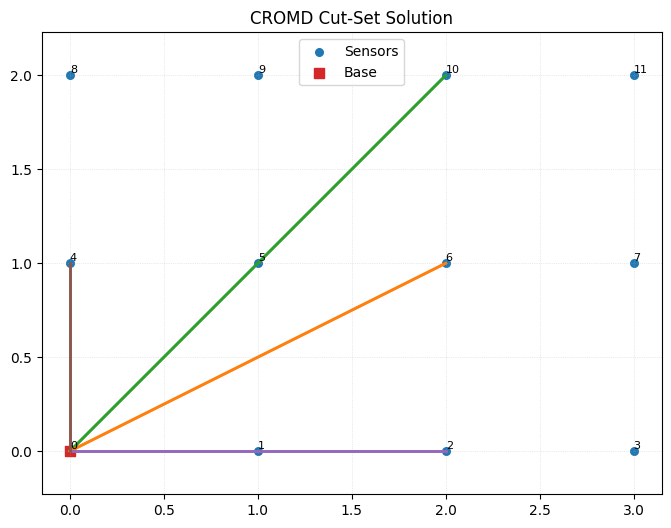

In [9]:
instance_utils.plot_instance_routes(DATA, result, show_coverage=False, title="CROMD Cut-Set Solution")